In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import math

from torch import nn
from tqdm import tqdm

In [7]:
class NeuralNetwork(nn.Module):

    activation_fn: callable

    def __init__(self, arq, activation_fn):

        super(NeuralNetwork, self).__init__()

        self.activation_fn = activation_fn

        self.neural_network = nn.ModuleList()
        
        for i in range(len(arq)-1):
            self.neural_network.append(nn.Linear(arq[i], arq[i+1]))
            nn.init.xavier_normal_(self.neural_network[i].weight)

    
    def forward(self, x):

        for layer in self.neural_network[:-1]: x = self.activation_fn(layer(x))
        x = self.neural_network[-1](x)  # Sem ativação na última camada
        return x
    
    def save(self, local: str):

        torch.save(self.state_dict(), local)

    def load(self, local: str):

        self.load_state_dict(torch.load(local))

In [8]:
class Inversive_PINN:

    def __init__(self):

        self.param = nn.Parameter(torch.tensor(1., requires_grad = True))

    def residual_loss(self, model, t, x, y):

        # Passagem da entrada pela rede
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)
        input = torch.stack([t, x, y], dim = 1)
        u = model(input)

        # Calculo dos gradientes
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # Resíduo da equação diferencial
        residual = u_t - (self.param * (u_xx + u_yy) + u)
        
        return torch.mean(residual**2)
    
    def data_loss(self, model, input, target):

        u_pred = model(input)
        return torch.mean((u_pred - target)**2)
    
    def trainning(self, model, x_data, u_data, x_ic_data, u_ic_data, x_residual, epochs = 1_000, learning_rate = 1e-3, step = 100):

        optmizer = torch.optim.Adam([
            {'params': model.parameters(), 'lr': 1e-3},
            {'params': [self.param], 'lr': 1e-3}
        ])
        loss_history = []

        for ep in range(epochs):

            optmizer.zero_grad()

            loss_data = self.data_loss(model, x_data, u_data)
            loss_ic = self.data_loss(model, x_ic_data, u_ic_data)
            loss_residual = self.residual_loss(model, x_residual[:, 0], x_residual[:, 1], x_residual[:, 2])

            loss = loss_residual + loss_data + loss_ic
            loss.backward()

            optmizer.step()

            if ep % step == 0 : print(f'Epoch {ep}, Loss: {loss.item()}, Lambda: {self.param.item()}')
            loss_history.append(loss.item())

        return loss_history


In [9]:
class Murray_2D:

    def __init__(self, l, tf, d, p, dx, dt, size):

        dl = d / (p * l**2)
        lb = (dl * dt) / dx**2

        gamma1 = 1. - 0.5 * dt + 2. * lb
        gamma2 = 1. + 0.5 * dt - 2. * lb

        a = np.zeros((size**2, size**2))
        b = np.zeros((size**2, size**2))

        for i in range(size**2):

            if i == 0:

                # CONDIÇÃO DE CONTORNO: VERTICE - BAIXO, ESQUERDA
                a[i,i], b[i,i] = 6, -6
                a[i,i+1], b[i,i+1] = -4, 4
                a[i,i+2], b[i,i+2] = 1, -1
                a[i,i+size], b[i,i+size] = -4, 4
                a[i,i+2*size], b[i, i+2*size] = 1, -1

            elif i == size-1:

                # CONDIÇÃO DE CONTORNO: VERTICE - BAIXO, DIREITA
                a[i,i], b[i,i] = 6, -6
                a[i,i-1], b[i,i-1] = -4, 4
                a[i,i-2], b[i,i-2] = 1, -1
                a[i,i+size], b[i,i+size] = -4, 4
                a[i,i+2*size], b[i,i+2*size] = 1, -1

            elif i == size**2 - size:

                # CONDIÇÃO DE CONTORNO: VERTICE - CIMA, ESQUERDA
                a[i,i], b[i,i] = 6, -6
                a[i,i+1], b[i,i+1] = -4, 4
                a[i,i+2], b[i,i+2] = 1, -1
                a[i,i-size], b[i,i-size] = -4, 4
                a[i,i-2*size], b[i, i-2*size] = 1, -1

            elif i == size**2 - 1:

                # CONDIÇÃO DE CONTORNO: VERTICE - CIMDA, DIREITA
                a[i,i], b[i,i] = 6, -6
                a[i,i-1], b[i,i-1] = -4, 4
                a[i,i-2], b[i,i-2] = 1, -1
                a[i,i-size], b[i,i-size] = -4, 4
                a[i,i-2*size], b[i,i-2*size] = 1, -1

            # CONDIÇÃO DE CONTORNO: BAIXO
            elif i > 0 and i < size-1:

                a[i, i], b[i,i] = 3 / (4. * dx), -3 / (4. * dx)
                a[i, i+size], b[i,i+size] =  -4 / (4. * dx), 4 / (4. * dx)
                a[i, i+2*size], b[i,i+2*size] =  1 / (4. * dx), - 1 / (4. * dx)

            # CONDIÇÃO DE CONTORNO: CIMA
            elif i > size**2 - size - 1 and i < size**2 - 1:

                a[i, i], b[i,i] = 3 / (4. * dx), -3 / (4. * dx)
                a[i, i-size], b[i,i-size] =  -4 / (4. * dx), 4 / (4. * dx)
                a[i, i-2*size], b[i,i-2*size] =  1 / (4. * dx), - 1 / (4. * dx)


            # CONDIÇÃO DE CONTORNO: ESQUERDA
            elif i%size == 0:

                a[i, i], b[i,i] = 3 / (4. * dx), -3 / (4. * dx)
                a[i, i+1], b[i,i+1] =  -4 / (4. * dx), 4 / (4. * dx)
                a[i, i+2], b[i,i+2] =  1 / (4. * dx), - 1 / (4. * dx)

            # CONDIÇÃO DE CONTORNO: DIREITA
            elif i%size == size-1:

                a[i, i], b[i,i] = 3 / (4. * dx), -3 / (4. * dx)
                a[i, i-1], b[i,i-1] =  -4 / (4. * dx), 4 / (4. * dx)
                a[i, i-2], b[i,i-2] =  1 / (4. * dx), - 1 / (4. * dx)

            # PONTOS INTERNOS
            else:

                a[i,i], b[i,i] = gamma1, gamma2
                a[i,i+1], b[i,i+1] = -0.5 * lb, 0.5 * lb
                a[i,i+size], b[i,i+size] = -0.5 * lb, 0.5 * lb
                a[i,i-1], b[i,i-1] = -0.5 * lb, 0.5 * lb
                a[i,i-size], b[i,i-size] = -0.5 * lb, 0.5 * lb

        self.a = a
        self.b = b

    def __call__(self, x):

        dir = self.b @ x
        return np.linalg.solve(self.a, dir)
    
    def solve(self, initial_condition, time):

        result = np.zeros((time, len(initial_condition)**2))
        result[0] = initial_condition.flatten()

        for i in tqdm(range(1, time)): result[i] = self.__call__(result[i-1])
        return result

In [10]:
# PARÂMETROS DIMENSIONAIS
l = 20
tf = 80
number_nodes = 50

#PARAMETROS DO MODELO
d = 0.0339
p = 0.0553

# DOMÍNIO
spatial = np.linspace(0, 1, number_nodes)
time = np.linspace(0, tf * p, tf)

dx = spatial[1]
dt = time[1]

In [119]:
class Forward_PINN:

    def __init__(self):

        self.param = d / (p * l**2)

    def residual_loss(self, model, t, x, y):

        # Passagem da entrada pela rede
        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)
        input = torch.stack([t, x, y], dim = 1)
        u = model(input)

        # Calculo dos gradientes
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # Resíduo da equação diferencial
        residual = u_t - (self.param * (u_xx + u_yy) + u)
        
        return torch.mean(residual**2)
    
    def data_loss(self, model, input, target):

        u_pred = model(input)
        return torch.mean((u_pred - target)**2)
    
    def trainning(self, model, x_data, u_data, x_ic_data, u_ic_data, x_residual, epochs = 1_000, learning_rate = 1e-3, step = 100):

        optmizer = torch.optim.Adam([
            {'params': model.parameters(), 'lr': 1e-3}
        ])

        loss_total = []
        loss_data = []
        loss_residual = []
        loss_ic = []

        for ep in tqdm(range(epochs)):

            optmizer.zero_grad()

            l_data = self.data_loss(model, x_data, u_data)
            l_ic = self.data_loss(model, x_ic_data, u_ic_data)
            l_residual = self.residual_loss(model, x_residual[:, 0], x_residual[:, 1], x_residual[:, 2])

            loss = l_data + l_ic + l_residual
            loss.backward()

            optmizer.step()

            loss_total.append(loss.item())
            loss_data.append(l_data.item())
            loss_residual.append(l_residual.item())
            loss_ic.append(l_ic.item())

        print(f'Loss: {loss.item()}')

        return loss_total, loss_data, loss_residual, loss_ic


In [12]:
def initial_condition(size):

    x = torch.linspace(0, 1, size)
    y = torch.linspace(0, 1, size)

    input = torch.cartesian_prod(x, y)
    f = lambda input: torch.exp(-100 * ((input[:, 0] - 0.5)**2 + (input[:, 1] - 0.5)**2))
    ic = f(input)

    return ic.view(size, size)

ic = initial_condition(number_nodes)
murray_2d = Murray_2D(l, tf, d, p, dx, dt, len(spatial))

data = murray_2d.solve(ic.detach().numpy(), tf)
tensor_data = torch.tensor(data)

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:23<00:00,  3.39it/s]


In [14]:
def generate_data(data_base, n_data=100, noise_level=0.05):

    t_size, x_size, y_size = data_base.shape

    if n_data > len(data_base.flatten()): 

        print(f'Tamanho n_data incompatível!!')
        return None, None

    x = torch.linspace(0, 1, x_size)
    y = torch.linspace(0, 1, y_size)
    t = torch.linspace(0, tf * p, t_size)

    input = torch.cartesian_prod(t, x, y)

    idx = np.random.choice(len(data_base.flatten()), n_data, replace=False)

    x_data = input[idx]
    u_data = tensor_data.flatten()[idx].view(-1, 1)
    u_data += noise_level * torch.randn_like(u_data)
    
    return x_data, u_data

def generate_ic_data(data_base, n_data):

    x_size, y_size = data_base.shape
    t = torch.tensor([0.])
    x = torch.linspace(0, 1, x_size)
    y = torch.linspace(0, 1, y_size)

    input = torch.cartesian_prod(t, x, y)

    idx = np.random.choice(len(data_base.flatten()), n_data, replace=False)

    x_data = input[idx]
    u_data = tensor_data.flatten()[idx].view(-1, 1)
    
    return x_data, u_data

In [ ]:
# Teste da geração de dados

#tensor_data = tensor_data.reshape(tf, number_nodes, number_nodes)
#x_data, u_data = generate_data(tensor_data, n_data = 1_000)
#x_ic_data, u_ic_data = generate_ic_data(tensor_data[0], n_data = 500)

#x_data.shape, u_data.shape, x_ic_data.shape, u_ic_data.shape

(torch.Size([1000, 3]),
 torch.Size([1000, 1]),
 torch.Size([500, 3]),
 torch.Size([500, 1]))

In [23]:
model = NeuralNetwork(
    [3] + 3 * [150] + [1],
    nn.Tanh()
)
inverse_pinn = Inversive_PINN()

x_data, u_data = generate_data(tensor_data, n_data = 1_000)
x_ic_data, u_ic_data = generate_ic_data(tensor_data[0], n_data = 1_000)
x_residual = torch.rand((1_000, 3)).requires_grad_(True)

In [103]:
print(f'Valor esperado: {d / (p * l**2)}\n\n')

loss_history = inverse_pinn.trainning(model, x_data, u_data, x_ic_data, u_ic_data, x_residual, epochs = 20_000, step = 1_000)

Valor esperado: 0.0015325497287522604


Epoch 0, Loss: 2.679492026652841, Lambda: 1.0010000467300415
Epoch 1000, Loss: 0.06686355652263332, Lambda: 0.056464631110429764
Epoch 2000, Loss: 0.025443478679681907, Lambda: -0.0006740331882610917
Epoch 3000, Loss: 0.017406022234392853, Lambda: -0.0003042685566470027
Epoch 4000, Loss: 0.016276805175800865, Lambda: -0.0002933109935838729
Epoch 5000, Loss: 0.015154080485476406, Lambda: -0.00022237520897760987
Epoch 6000, Loss: 0.015520173132238232, Lambda: -0.0003246359992772341
Epoch 7000, Loss: 0.014036280947569688, Lambda: -0.0003013743262272328
Epoch 8000, Loss: 0.01354255835592362, Lambda: -0.0003295293136034161
Epoch 9000, Loss: 0.013810364681704409, Lambda: -0.0003654064785223454
Epoch 10000, Loss: 0.01292485470413841, Lambda: -0.000258878106251359
Epoch 11000, Loss: 0.01264716804889166, Lambda: -0.0001907957048388198
Epoch 12000, Loss: 0.011872341884658117, Lambda: -0.00014620278670918196
Epoch 13000, Loss: 0.011339872406623396, Lambda: 

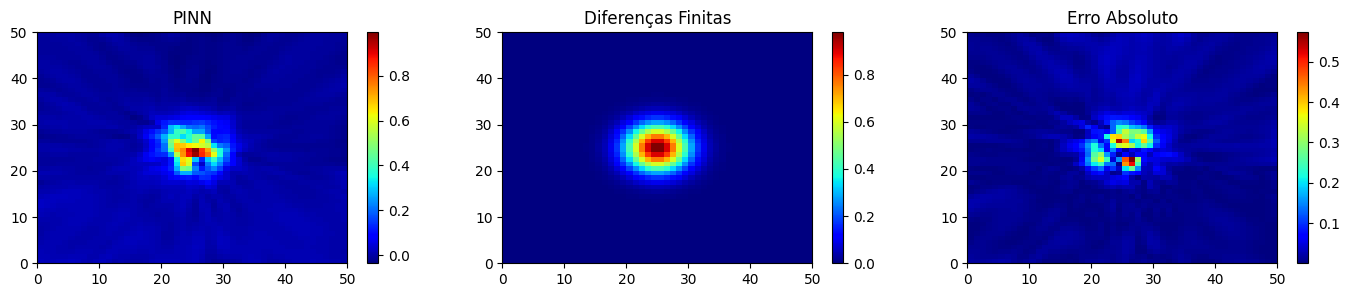

In [ ]:
t = torch.linspace(0, tf * p, tf)
x = torch.linspace(0, 1, 50)
y = torch.linspace(0, 1, 50)
input = torch.cartesian_prod(t, x, y)
pred = model(input).detach().numpy()


data = data.reshape(tf, 50, 50)
pred = pred.reshape(tf, 50, 50)

fig, ax = plt.subplots(ncols = 3, figsize = (17, 3))

i = 0
p1 = ax[0].pcolormesh(pred[i], cmap = 'jet')
ax[0].set_title('PINN')


p2 = ax[1].pcolormesh(data[i], cmap = 'jet')
ax[1].set_title('Diferenças Finitas')

p3 = ax[2].pcolormesh(abs(pred[i] - data[i]), cmap = 'jet')
ax[2].set_title('Erro Absoluto')

plt.colorbar(p1)
plt.colorbar(p2)
plt.colorbar(p3)
plt.show()

In [124]:
model = NeuralNetwork(
    [3] + 3 * [150] + [1],
    nn.Tanh()
)
forward_pinn = Forward_PINN()

tensor_data = tensor_data.reshape(tf, number_nodes, number_nodes)
x_data, u_data = generate_data(tensor_data, n_data = 1_000)
x_ic_data, u_ic_data = generate_ic_data(tensor_data[0], n_data = 1_000)
x_residual = torch.rand((6_000, 3)).requires_grad_(True)

In [ ]:
loss_total, loss_data, loss_residual, loss_ic = forward_pinn.trainning(model, x_data, u_data, x_ic_data, u_ic_data, x_residual, epochs = 20_000, step = 1_000)

  1%|▏         | 276/20000 [02:30<3:00:31,  1.82it/s]

Erro: 0.06141986260725143


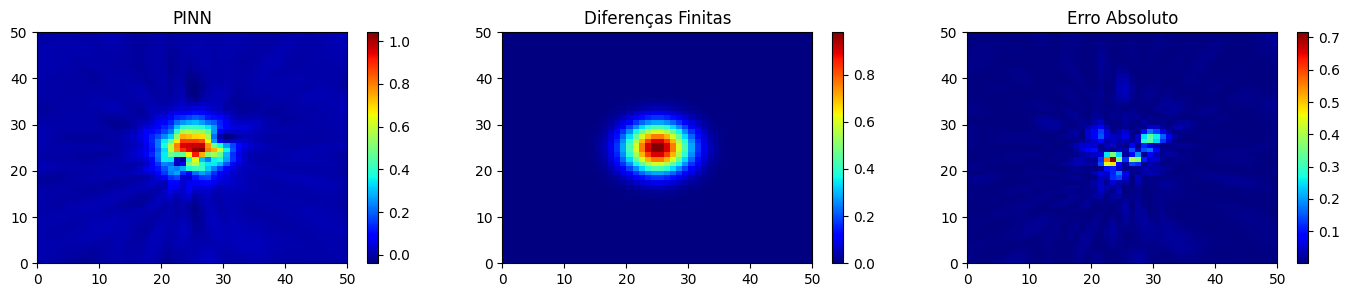

In [117]:
t = torch.linspace(0, tf * p, tf)
x = torch.linspace(0, 1, 50)
y = torch.linspace(0, 1, 50)
input = torch.cartesian_prod(t, x, y)
pred = model(input).detach().numpy()


data = data.reshape(tf, 50, 50)
pred = pred.reshape(tf, 50, 50)
print(f'Erro: {(abs(pred - data)).mean().item()}')

fig, ax = plt.subplots(ncols = 3, figsize = (17, 3))

i = 0
p1 = ax[0].pcolormesh(pred[i], cmap = 'jet')
ax[0].set_title('PINN')

p2 = ax[1].pcolormesh(data[i], cmap = 'jet')
ax[1].set_title('Diferenças Finitas')

p3 = ax[2].pcolormesh(abs(pred[i] - data[i]), cmap = 'jet')
ax[2].set_title('Erro Absoluto')

plt.colorbar(p1)
plt.colorbar(p2)
plt.colorbar(p3)

plt.show()

np.float64(0.05148787246241831)

In [ ]:
import pandas as pd 
import seaborn as sb 

df = pd.DataFrame(data = {
    'Iterações': [i for i in range(len(loss_total))],
    'Total': loss_total,
    'Dados': loss_data,
    'Residuo': loss_residual,
    'Condição Inicial': loss_ic
})

df

,Iterações,Total,Dados,Residuo,Condição Inicial
0,0,5.167357,5.075208,0.079219,1.292976e-02
1,1,4.801243,4.166707,0.504835,1.297000e-01
2,2,3.971636,3.925351,0.019775,2.651025e-02
3,3,4.305383,3.830971,0.113823,3.605889e-01
4,4,4.260589,3.844812,0.100990,3.147868e-01
...,...,...,...,...,...
9995,9995,0.001341,0.001163,0.000162,1.684248e-05
9996,9996,0.001397,0.001246,0.000133,1.884175e-05
9997,9997,0.001156,0.001151,0.000005,5.551115e-11
9998,9998,0.001153,0.001064,0.000062,2.747315e-05


In [81]:
(df['Condição Inicial'] >= df['Dados'])

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [70]:
df_percent = pd.DataFrame(data = {
    'Iterações': [i for i in range(len(loss_total))],
    'Dados': np.abs(df['Dados'] / df['Total']),
    'Residuo': np.abs(df['Residuo'] / df['Total']),
    'Condição Inicial': np.abs(df['Condição Inicial'] / df['Total']),
})

df_percent['Dados'].mean(), df_percent['Residuo'].mean(), df_percent['Condição Inicial'].mean()

(np.float64(0.9598285136797297),
 np.float64(0.01894153671940269),
 np.float64(0.021229949600867683))

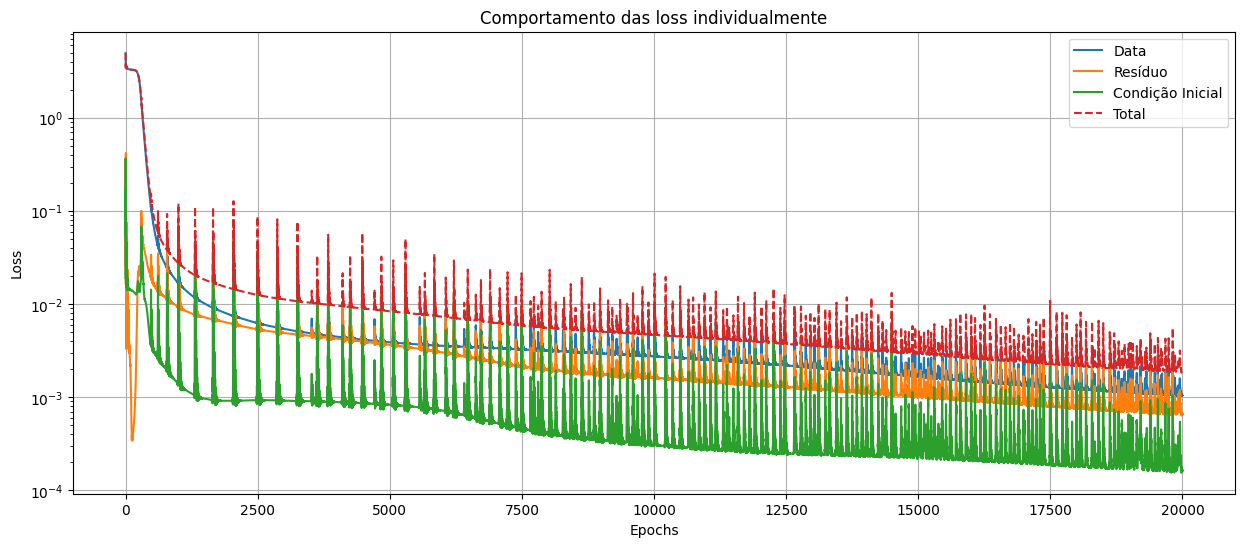

In [118]:
fig, ax = plt.subplots(figsize = (15, 6))

plt.plot(loss_data, label = 'Data')
plt.plot(loss_residual, label = 'Resíduo')
plt.plot(loss_ic, label = 'Condição Inicial')
plt.plot(loss_total, label = 'Total', linestyle = 'dashed')

plt.title('Comportamento das loss individualmente')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')
plt.legend()
plt.grid()
plt.show()